In [2]:
pip install deap

     |████████████████████████████████| 153kB 5.1MB/s 


In [10]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, ngpu, nc, nz, ngf):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 7, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 7 x 7
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 7 x 7
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 14 x 14
            nn.ConvTranspose2d(ngf * 2, ngf, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 14 x 14
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 28 x 28
        )

    def forward(self, input):
        return self.main(input)

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def imshow(img):
    img = (img + 1) / 2
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

def imshow_grid(img):
    img = utils.make_grid(img.cpu().detach())
    img = (img + 1) / 2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Hyper parameters
params = {
    'input_size': 28,  # image size 1x64x64
    'batch_size': 64,  # batch size
    'pop_size': 100,   # population size
    'nc': 1,  # number of channels
    'nz': 100,  # size of z latent vector
    'ngf': 64,  # size of feature maps in generator
    'ndf': 32,  # size of feature maps in discriminator
    'num_epochs': 1000,  # number of epochs
    'lr': 0.0001,  # learning rate
    'beta1': 0.5,   # beta1 for adam optimizer
    'ngpu': 1,  # number of GPU
    'lambda_gp': 10,  # loss weight for gradient penalty
    'n_critic': 5,
}

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Generator(ngpu, nc, nz, ngf)
# 이 부분에서 체크포인트 위치 설정.
netG = Generator(params['ngpu'], params['nc'], params['nz'], params['ngf'])
netG.load_state_dict(torch.load(gdrive_root + '/checkpoints/netG_12500.pth', map_location=torch.device('cpu')))

# transform
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])
# data sets and data loader
train_data = datasets.MNIST(root='data/', train=True, transform=transform, download=True)
train_data_loader = DataLoader(train_data, params['batch_size'], shuffle=False)
first_batch = train_data_loader.__iter__().__next__()  # first batch of MNIST data set : torch.Size([64x, 1, 28, 28])
print(first_batch[0][0].shape)  # torch.Size([1, 28, 28])
#imshow(first_batch[0][0])  # plot the image of first batch

torch.Size([1, 28, 28])


In [34]:
import random
from deap import creator, base, tools, algorithms

# TOCHECK:  will we use algorithm modules?

'''
Fitness : single optimization, minimize ||G(z) - x||^2_2
'''
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMin) # minimizing the fitness value

toolbox = base.Toolbox()

'''
[HYPERPARAMETERS]
List of Floats: individuals composed of 'IND_SIZE' floating point numbers
IND_SIZE: z의 dimension으로 보면 될듯
POPULATION
CXPB: probability of crossover
MUTPB: probability of mutation
'''
IND_SIZE = 100
POPULATION = 100
CXPB, MUTPB = 0.2, 0.2
GENERATIONS = 100

toolbox.register("attr_float", random.random)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=IND_SIZE)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def cxTwoPointCopy(ind1, ind2):
    """Execute a two points crossover with copy on the input individuals. The
    copy is required because the slicing in numpy returns a view of the data,
    which leads to a self overwritting in the swap operation. It prevents
    ::
    
        >>> import numpy
        >>> a = numpy.array((1,2,3,4))
        >>> b = numpy.array((5,6,7,8))
        >>> a[1:3], b[1:3] = b[1:3], a[1:3]
        >>> print(a)
        [1 6 7 4]
        >>> print(b)
        [5 6 7 8]
    """
    size = len(ind1)
    cxpoint1 = random.randint(1, size)
    cxpoint2 = random.randint(1, size - 1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else: # Swap the two cx points
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1

    ind1[cxpoint1:cxpoint2], ind2[cxpoint1:cxpoint2] \
        = ind2[cxpoint1:cxpoint2].copy(), ind1[cxpoint1:cxpoint2].copy()
        
    return ind1, ind2

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


194.0220860870113
[[-0.26212975 -0.22245978 -1.1557736  ... -1.2895316   0.8864686
   0.08005337]
 [-0.10363276  1.8579419   1.8164245  ... -0.49195328  2.1127563
  -1.1015389 ]
 [ 0.2393099  -0.8281347   0.4849926  ...  0.369192   -0.11912449
   1.9289007 ]
 ...
 [ 0.00963861 -0.990944   -0.7005533  ...  0.44421026 -0.06784059
  -0.6683479 ]
 [ 0.7677108  -0.13975468 -0.82682866 ... -0.21326618  1.9265594
   0.01750526]
 [-0.21674751  0.80773485 -0.16027735 ...  1.0120332   1.6141067
  -0.39148426]]
the shape of latent vector : torch.Size([1, 100, 1, 1])
the shape of generated image : torch.Size([1, 1, 28, 28])


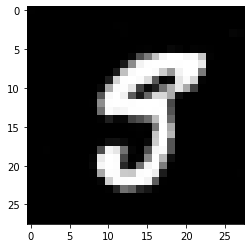

In [85]:
# Input image for defense GAN
# For the test purpose, we will use MNIST data sample first.
# fgsm_image : torch.Size([1, 28, 28]). This is image x.
fgsm_image = first_batch[0][0]  # torch.Size([1, 28, 28]). This should be fgsm_image later on.

# evalFunc 에서 numpy 형태로 계산하려고 모양 수정 / 일단은 그냥 28, 28로 했는데 나중엔 일렬로 계산해도 될 듯.
x = fgsm_image.view(28,28).numpy()
#imshow(fgsm_image)

# individual은 numpy array
# numpy array 가 들어오면 -> tensor로 바꾸고, netG input 모양에 맞춰줌.
# netG의 output이 tensor 형태이므로, numpy로 바꿔서 계산.. (이부분 텐서 형태에서 계산으로 추후 수정하면 될 듯.)
def evalFunc(individual):
    individual = torch.from_numpy(individual).view(1, 100, 1, 1)
    return np.linalg.norm(netG(individual).view(28, 28).detach().numpy() - x, ord=2)**2

# Initial population for GA
# initial_population : torch.Size([100, 100, 1, 1]), This has 100 latent vectors z (z is torch.Size([100, 1, 1])).
# for example, initial_population[0] is z_0, initial_population[1] is z_1, ..., initial_population[99] is z_99.
initial_population = torch.FloatTensor(params['pop_size'], params['nz'], 1, 1).normal_(0, 1)
#print(initial_population.shape)  # torch.Size([100, 100, 1, 1])


# 이 부분은 evalFunc 이 잘 작동하는지 확인하는 부분입니당.
# z 가 길이 100짜리 1차원 numpy array 라고 가정하고(GA 에서 기본 individual 형태) evalFunc에 넣은뒤, 출력
z = torch.FloatTensor(1, params['nz'], 1, 1).normal_(0, 1)
z = z.view(100).numpy()
print(evalFunc(z))

# initial_population를 numpy로 타입 맞춰주기.
initial_population = initial_population.view(100, 100).numpy()

#########################
# Do the GA from here!! # or gradient descent
#########################
# Thought : manipulating latent vectors is important since domain is specified (z is normal dist.)
# and, GA should have high converging power.

# For each generation, select the latent vector z* that minimizes fitness, and do the following.
z = torch.FloatTensor(1, params['nz'], 1, 1).normal_(0, 1)  # torch.Size([100, 1, 1]). This should be z* later on.
print("the shape of latent vector : " + str(z.shape))
gen_image = netG(z)  # torch.Size([1, 28, 28]). This is the generated image that we want to see for each generation.
# Because gen_image should step closer to fgsm_image x for each generation.
print("the shape of generated image : " + str(gen_image.shape))
imshow(gen_image.detach())  # plot the image of generated image

# After GA, give generated image as input to each classifier (use gen_image)